# 3D-BPP

## Pre-requisites

In [19]:
%pip install numpy
%pip install pandas
%pip install ortools
%pip install matplotlib
%pip install ipympl
%pip install rectpack
%pip install tqdm
%pip install scipy
%pip install seaborn
%pip install streamlit
%pip install watchdogs
%pip install loguru


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached ipympl-0.9.3-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl.metadata (755 bytes)
Using cached ipympl-0.9.3-py2.py3-none-any.whl (511 kB)
Using cached ipython_genutils-0.2

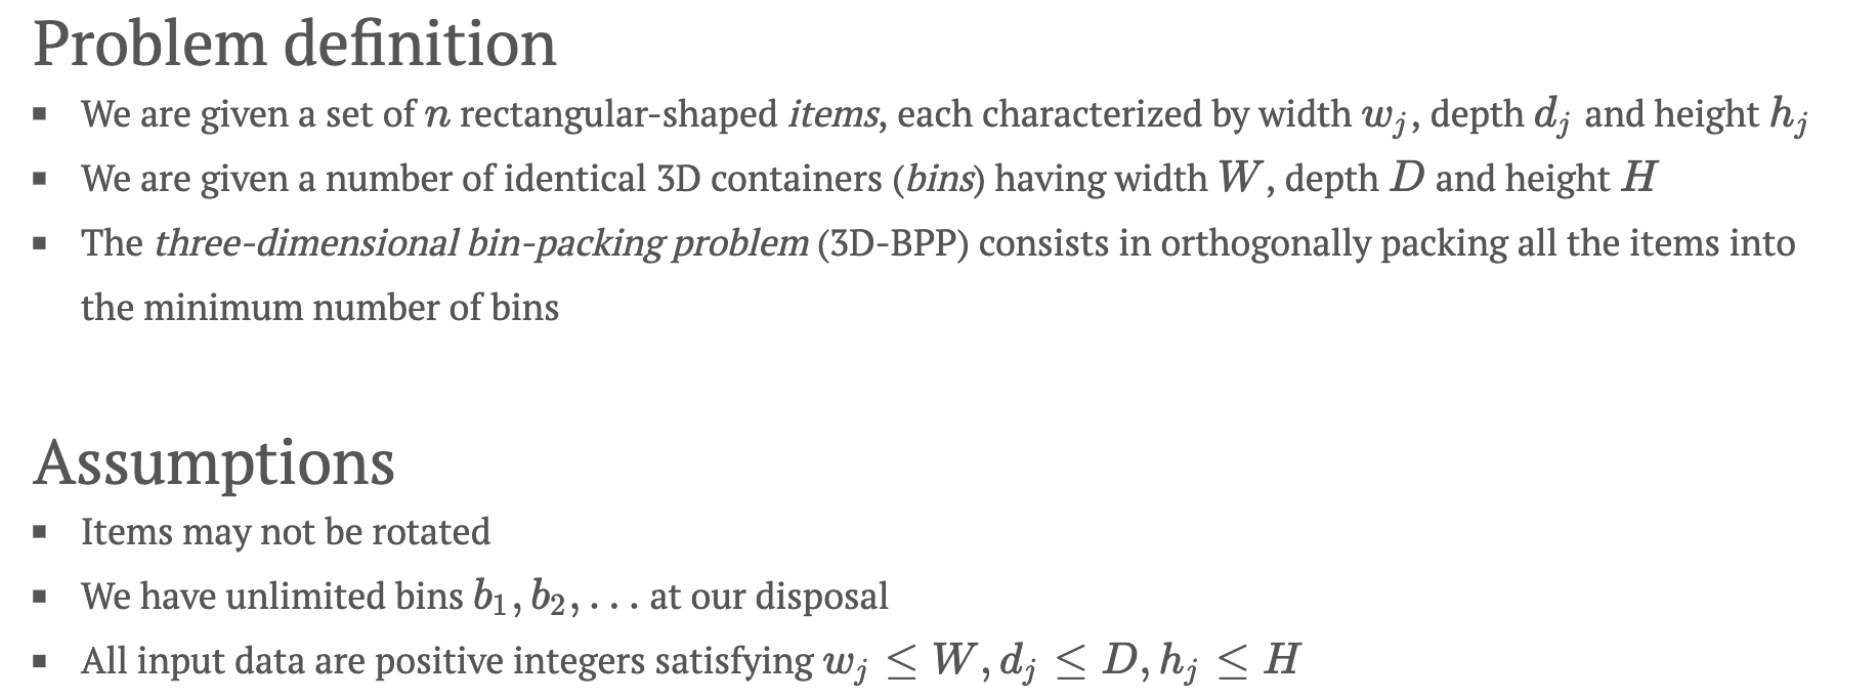

In [70]:
from IPython.display import Image
display(Image(filename='/Users/b0r07h4/Desktop/Work/BITS WORK SHOP/3d-bpp-main/assets/ProblemStatement.png',width=600))

In [4]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [9]:
product_dataset = pd.read_pickle("./data/products.pkl")
product_dataset

,width,depth,height,weight,volume
0,284,226,119,25,7637896
1,299,207,137,90,8479341
2,534,372,229,41,45490392
3,295,134,232,31,9170960
4,266,186,178,54,8806728
...,...,...,...,...,...
999995,264,191,189,2,9530136
999996,493,362,165,3,29446890
999997,281,218,104,2,6370832
999998,400,192,343,2,26342400


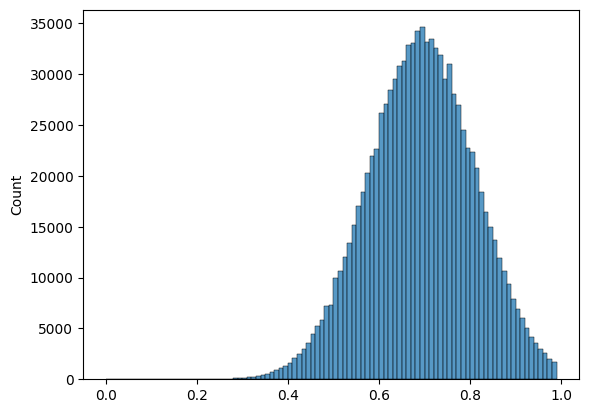

In [10]:
plt.figure()
sns.histplot(
    product_dataset.depth / product_dataset.width,
    bins=np.arange(0, 1, 0.01),
)
plt.show()

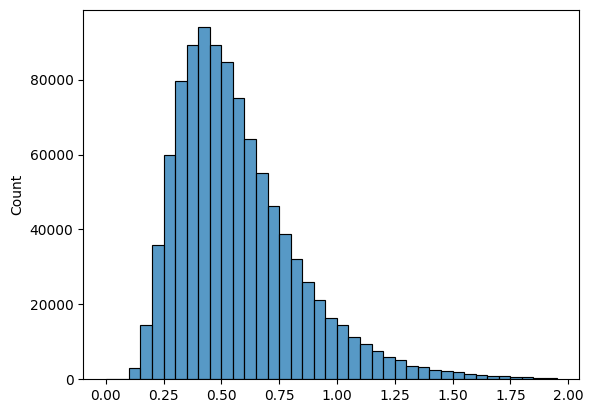

In [11]:
plt.figure()
sns.histplot(
    product_dataset.height / product_dataset.width,
    bins=np.arange(0, 2, 0.05),
)
plt.show()

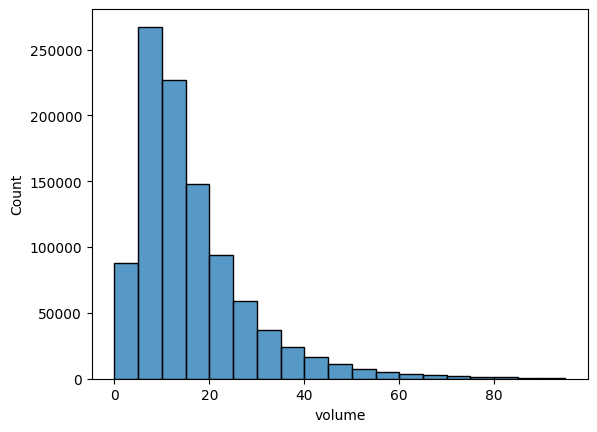

In [12]:
plt.figure()
sns.histplot(product_dataset.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

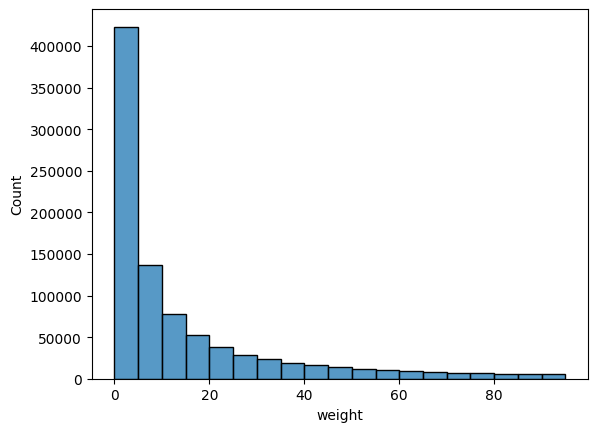

In [13]:
plt.figure()
sns.histplot(product_dataset.weight, bins=np.arange(0, 100, 5))
plt.show()

### Order

In [24]:
# get random  orders

In [25]:
def get_order(products,ordered_products):
        order = products.sample(ordered_products, replace=True)
        ids = pd.Series(order.index, name="id")
        return pd.concat([ids, order.reset_index(drop=True)], axis=1)

ordered_products = 2
order = get_order(product_dataset,ordered_products)
order

,id,width,depth,height,weight,volume
0,958133,433,332,188,2,27026128
1,930991,386,270,386,2,40228920


### Utils

In [20]:
import itertools
from collections import Counter
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm

class Dimension:
    """
    Helper class to define object dimensions
    """

    def __init__(self, width, depth, height, weight=0):
        self.width = int(width)
        self.depth = int(depth)
        self.height = int(height)
        self.weight = int(weight)
        self.area = int(width * depth)
        self.volume = int(width * depth * height)

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return (
                self.width == other.width
                and self.depth == other.depth
                and self.height == other.height
                and self.weight == other.weight
            )
        return False

    def __ne__(self, other):
        return not self.__eq__(other)

    def __str__(self):
        return (
            f"Dimension(width={self.width}, depth={self.depth}, height={self.height}, "
            f"weight={self.weight}, volume={self.volume})"
        )

    def __repr__(self):
        return self.__str__()


class Coordinate:
    """
    Helper class to define a pair/triplet of coordinates
    (defined as the bottom-left-back point of a cuboid)
    """

    def __init__(self, x, y, z=0):
        self.x = int(x)
        self.y = int(y)
        self.z = int(z)

    def from_blb_to_vertices(self, dims):
        """
        Convert bottom-left-back coordinates to
        the list of all vertices in the cuboid
        """
        assert isinstance(dims, Dimension), "The given dimension should be an instance of Dimension"
        blb = self
        blf = Coordinate(self.x + dims.width, self.y, self.z)
        brb = Coordinate(self.x, self.y + dims.depth, self.z)
        brf = Coordinate(self.x + dims.width, self.y + dims.depth, self.z)
        tlb = Coordinate(self.x, self.y, self.z + dims.height)
        tlf = Coordinate(self.x + dims.width, self.y, self.z + dims.height)
        trb = Coordinate(self.x, self.y + dims.depth, self.z + dims.height)
        trf = Coordinate(self.x + dims.width, self.y + dims.depth, self.z + dims.height)
        return [blb, blf, brb, brf, tlb, tlf, trb, trf]

    def to_numpy(self):
        """
        Convert coordinates to a numpy list
        """
        return np.array([self.x, self.y, self.z])

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.x == other.x and self.y == other.y and self.z == other.z
        return False

    def __ne__(self, other):
        return not self.__eq__(other)

    def __str__(self):
        return f"Coordinate(x={self.x}, y={self.y}, z={self.z})"

    def __repr__(self):
        return self.__str__()

    def __hash__(self):
        return hash(str(self))


class Vertices:
    """
    Helper class to define the set of vertices identifying a cuboid
    """

    def __init__(self, blb, dims):
        assert isinstance(
            blb, Coordinate
        ), "The given coordinate should be an instance of Coordinate"
        assert isinstance(dims, Dimension), "The given dimension should be an instance of Dimension"
        self.dims = dims

        # Bottom left back and front
        self.blb = blb
        self.blf = Coordinate(self.blb.x + self.dims.width, self.blb.y, self.blb.z)

        # Bottom right back and front
        self.brb = Coordinate(self.blb.x, self.blb.y + self.dims.depth, self.blb.z)
        self.brf = Coordinate(
            self.blb.x + self.dims.width, self.blb.y + self.dims.depth, self.blb.z
        )

        # Top left back and front
        self.tlb = Coordinate(self.blb.x, self.blb.y, self.blb.z + self.dims.height)
        self.tlf = Coordinate(
            self.blb.x + self.dims.width, self.blb.y, self.blb.z + self.dims.height
        )

        # Top right back and front
        self.trb = Coordinate(
            self.blb.x, self.blb.y + self.dims.depth, self.blb.z + self.dims.height
        )
        self.trf = Coordinate(
            self.blb.x + self.dims.width,
            self.blb.y + self.dims.depth,
            self.blb.z + self.dims.height,
        )

        # List of vertices
        self.vertices = [
            self.blb,
            self.blf,
            self.brb,
            self.brf,
            self.tlb,
            self.tlf,
            self.trb,
            self.trf,
        ]

    def get_center(self):
        """
        Return the central coordinate of the cuboid
        """
        return Coordinate(
            self.blb.x + self.dims.width // 2,
            self.blb.y + self.dims.depth // 2,
            self.blb.z + self.dims.height // 2,
        )

    def get_xs(self):
        """
        Return a numpy array containing all the x-values
        of the computed vertices
        """
        return np.array([v.x for v in self.vertices])

    def get_ys(self):
        """
        Return a numpy array containing all the y-values
        of the computed vertices
        """
        return np.array([v.y for v in self.vertices])

    def get_zs(self):
        """
        Return a numpy array containing all the z-values
        of the computed vertices
        """
        return np.array([v.z for v in self.vertices])

    def to_faces(self):
        """
        Convert the computed set of vertices to a list of faces
        (6 different faces for one cuboid)
        """
        return np.array(
            [
                [
                    self.blb.to_numpy(),
                    self.blf.to_numpy(),
                    self.brf.to_numpy(),
                    self.brb.to_numpy(),
                ],  # bottom
                [
                    self.tlb.to_numpy(),
                    self.tlf.to_numpy(),
                    self.trf.to_numpy(),
                    self.trb.to_numpy(),
                ],  # top
                [
                    self.blb.to_numpy(),
                    self.brb.to_numpy(),
                    self.trb.to_numpy(),
                    self.tlb.to_numpy(),
                ],  # back
                [
                    self.blf.to_numpy(),
                    self.brf.to_numpy(),
                    self.trf.to_numpy(),
                    self.tlf.to_numpy(),
                ],  # front
                [
                    self.blb.to_numpy(),
                    self.blf.to_numpy(),
                    self.tlf.to_numpy(),
                    self.tlb.to_numpy(),
                ],  # left
                [
                    self.brb.to_numpy(),
                    self.brf.to_numpy(),
                    self.trf.to_numpy(),
                    self.trb.to_numpy(),
                ],  # right
            ]
        )


def argsort(seq, reverse=False):
    """
    Sort the given array and return indices instead of values
    """
    return sorted(range(len(seq)), key=seq.__getitem__, reverse=reverse)


def duplicate_keys(dicts):
    """
    Check that the input dictionaries have common keys
    """
    keys = list(flatten([d.keys() for d in dicts]))
    return [k for k, v in Counter(keys).items() if v > 1]


def flatten(l):
    """
    Given nested Python lists, return their flattened version
    """
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el


def do_overlap(a, b):
    """
    Check if the given items strictly overlap or not
    (both items should be given as a Pandas Series)
    """
    assert isinstance(a, pd.Series) and isinstance(b, pd.Series), "Wrong input types"
    dx = min(a.x.item() + a.width.item(), b.x.item() + b.width.item()) - max(a.x.item(), b.x.item())
    dy = min(a.y.item() + a.depth.item(), b.y.item() + b.depth.item()) - max(a.y.item(), b.y.item())
    if (dx > 0) and (dy > 0):
        return True
    return False


def get_pallet_plot(pallet_dims):
    """
    Compute an initial empty 3D-plot with the pallet dimensions
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_facecolor("xkcd:white")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.text(0, 0, 0, "origin", size=10, zorder=1, color="k")
    ax.view_init(azim=60)
    ax.set_xlim3d(0, pallet_dims.width)
    ax.set_ylim3d(0, pallet_dims.depth)
    ax.set_zlim3d(0, pallet_dims.height)
    return ax


def plot_product(ax, item_id, coords, dims):
    """
    Add product to given axis
    """
    vertices = Vertices(coords, dims)
    ax.scatter3D(vertices.get_xs(), vertices.get_ys(), vertices.get_zs())
    ax.add_collection3d(
        Poly3DCollection(
            vertices.to_faces(),
            facecolors=np.random.rand(1, 3),
            linewidths=1,
            edgecolors="r",
            alpha=0.45,
        )
    )
    center = vertices.get_center()
    ax.text(
        center.x,
        center.y,
        center.z,
        item_id,
        size=10,
        zorder=1,
        color="k",
    )
    return ax


def get_l0_lb(order, pallet_dims):
    """
    L0 lower bound (aka continuos lower bound) for the
    minimum number of required bins. The worst case
    performance of this bound is 1 / 8.

    Silvano Martello, David Pisinger and Daniele Vigo,
    "The Three-Dimensional Bin Packing Problem",
    Operations Research, 1998.
    """
    return np.ceil(order.volume.sum() / pallet_dims.volume)


def get_l1_lb(order, pallet_dims):
    """
    L1 lower bound for the minimum number of required bins.
    The worst-case performance of L1 can be arbitrarily bad.

    Silvano Martello, David Pisinger and Daniele Vigo,
    "The Three-Dimensional Bin Packing Problem",
    Operations Research, 1998.
    """

    def get_j2(d1, bd1, d2, bd2):
        return order[(order[d1] > (bd1 / 2)) & (order[d2] > (bd2 / 2))]

    def get_js(j2, p, d, bd):
        return j2[(j2[d] >= p) & (j2[d] <= (bd / 2))]

    def get_jl(j2, p, d, bd):
        return j2[(j2[d] > (bd / 2)) & (j2[d] <= bd - p)]

    def get_l1j2(d1, bd1, d2, bd2, d3, bd3):
        j2 = get_j2(d1, bd1, d2, bd2)
        if len(j2) == 0:
            return 0.0
        ps = order[order[d3] <= bd3 / 2][d3].values
        max_ab = -np.inf
        for p in tqdm(ps):
            js = get_js(j2, p, d3, bd3)
            jl = get_jl(j2, p, d3, bd3)
            a = np.ceil((js[d3].sum() - (len(jl) * bd3 - jl[d3].sum())) / bd3)
            b = np.ceil((len(js) - (np.floor((bd3 - jl[d3].values) / p)).sum()) / np.floor(bd3 / p))
            max_ab = max(max_ab, a, b)

        return len(j2[j2[d3] > (bd3 / 2)]) + max_ab

    l1wh = get_l1j2(
        "width", pallet_dims.width, "height", pallet_dims.height, "depth", pallet_dims.depth
    )
    l1wd = get_l1j2(
        "width", pallet_dims.width, "depth", pallet_dims.depth, "height", pallet_dims.height
    )
    l1dh = get_l1j2(
        "depth", pallet_dims.depth, "width", pallet_dims.width, "height", pallet_dims.height
    )
    return max(l1wh, l1wd, l1dh), l1wh, l1wd, l1dh


def get_l2_lb(order, pallet_dims):
    """
    L2 lower bound for the minimum number of required bins
    The worst-case performance of this bound is 2 / 3.

    Silvano Martello, David Pisinger and Daniele Vigo,
    "The Three-Dimensional Bin Packing Problem",
    Operations Research, 1998.
    """

    def get_kv(p, q, d1, bd1, d2, bd2):
        return order[(order[d1] > bd1 - p) & (order[d2] > bd2 - q)]

    def get_kl(kv, d1, bd1, d2, bd2):
        kl = order[~order.isin(kv)]
        return kl[(kl[d1] > (bd1 / 2)) & (kl[d2] > (bd2 / 2))]

    def get_ks(kv, kl, p, q, d1, d2):
        ks = order[~order.isin(pd.concat([kv, kl], axis=0))]
        return ks[(ks[d1] >= p) & (ks[d2] >= q)]

    def get_l2j2pq(p, q, l1, d1, bd1, d2, bd2, d3, bd3):
        kv = get_kv(p, q, d1, bd1, d2, bd2)
        kl = get_kl(kv, d1, bd1, d2, bd2)
        ks = get_ks(kv, kl, p, q, d1, d2)

        return l1 + max(
            0,
            np.ceil(
                (pd.concat([kl, ks], axis=0).volume.sum() - (bd3 * l1 - kv[d3].sum()) * bd1 * bd2)
                / (bd1 * bd2 * bd3)
            ),
        )

    def get_l2j2(l1, d1, bd1, d2, bd2, d3, bd3):
        ps = order[(order[d1] <= bd1 // 2)][d1].values
        qs = order[(order[d2] <= bd2 // 2)][d2].values
        max_l2j2 = -np.inf
        for p, q in tqdm(itertools.product(ps, qs)):
            l2j2 = get_l2j2pq(p, q, l1, d1, bd1, d2, bd2, d3, bd3)
            max_l2j2 = max(max_l2j2, l2j2)
        return max_l2j2

    _, l1wh, l1wd, l1hd = get_l1_lb(order, pallet_dims)
    l2wh = get_l2j2(
        l1wh, "width", pallet_dims.width, "height", pallet_dims.height, "depth", pallet_dims.depth
    )
    l2wd = get_l2j2(
        l1wd, "width", pallet_dims.width, "depth", pallet_dims.depth, "height", pallet_dims.height
    )
    l2dh = get_l2j2(
        l1hd, "depth", pallet_dims.depth, "height", pallet_dims.height, "width", pallet_dims.width
    )
    return max(l2wh, l2wd, l2dh), l2wh, l2wd, l2dh


### SuperItems

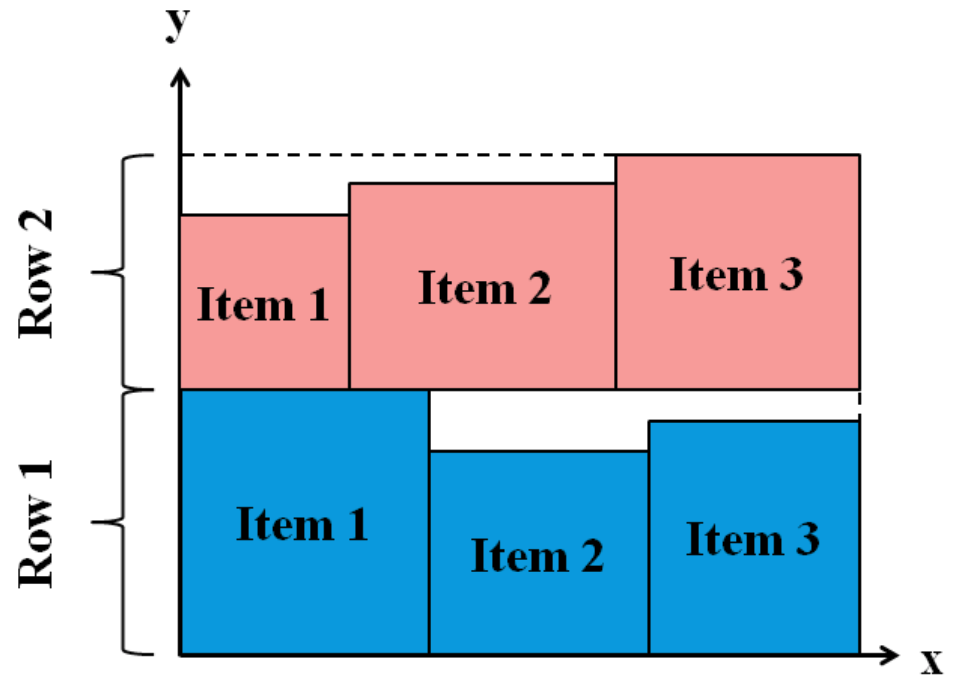

In [71]:
Image(filename='/Users/b0r07h4/Desktop/Work/BITS WORK SHOP/3d-bpp-main/assets/2d-layers.png',width=400)

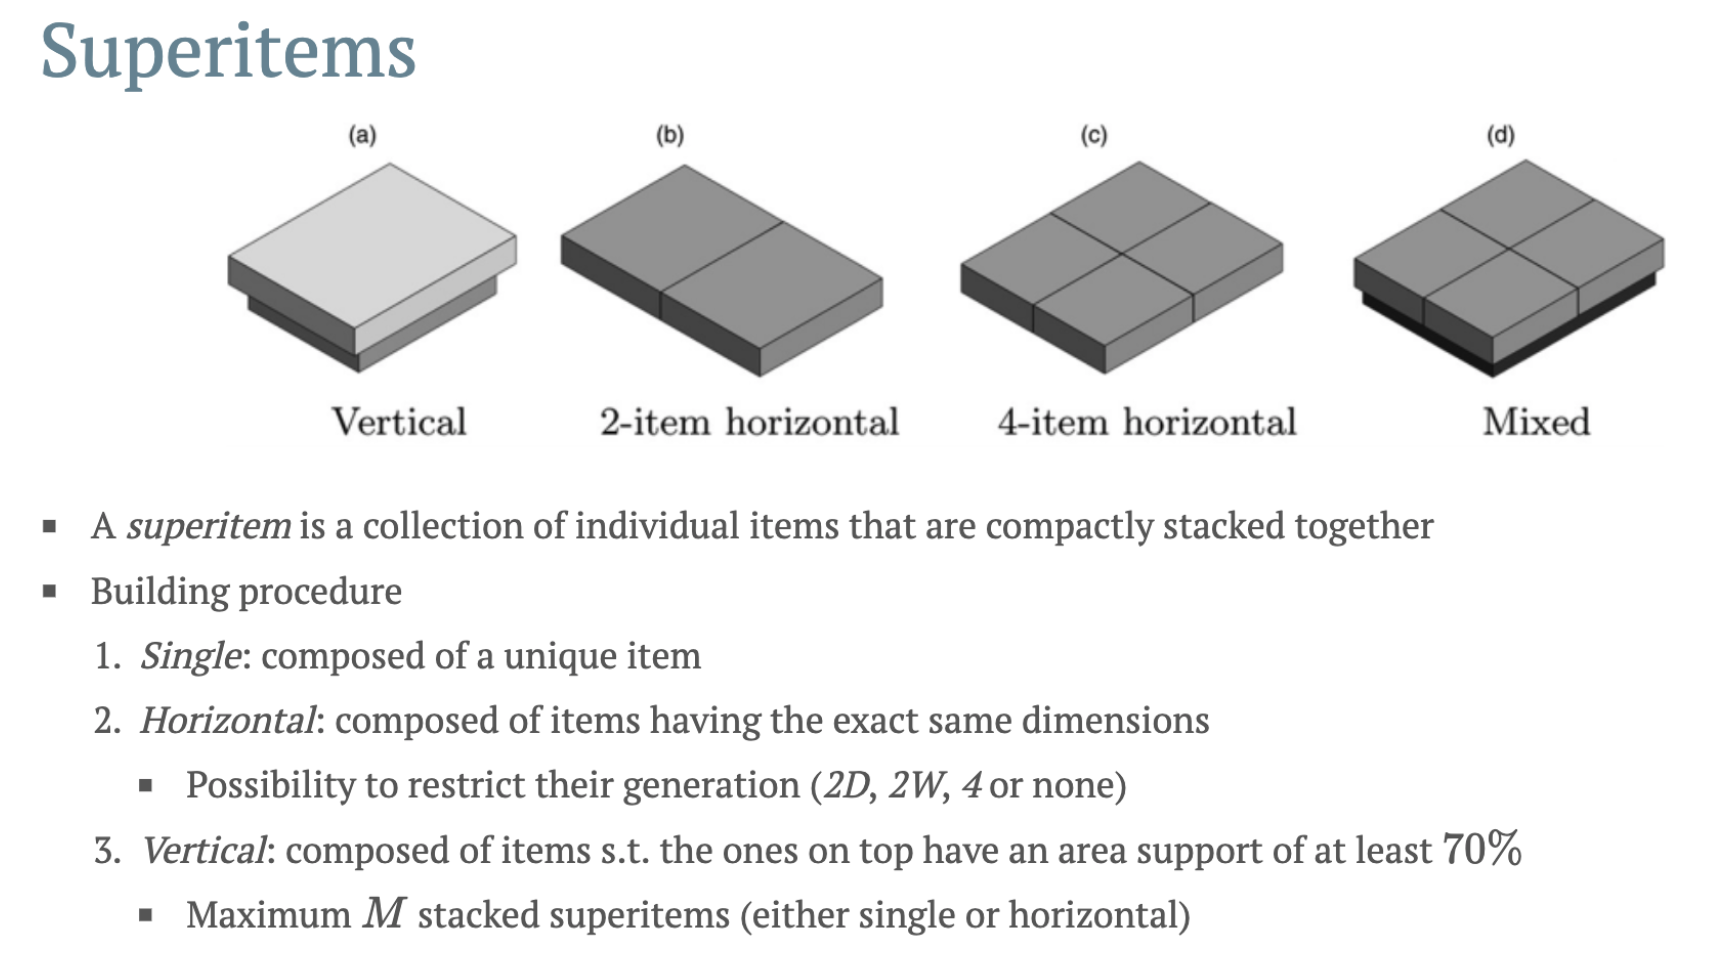

In [73]:
Image(filename='/Users/b0r07h4/Desktop/Work/BITS WORK SHOP/3d-bpp-main/assets/SuperItemDef.png',width=600)

In [19]:
from collections import defaultdict

import numpy as np
import pandas as pd
from loguru import logger

class Item:
    """
    An item is a single product with a unique identifier
    and a list of spatial dimensions
    """

    def __init__(self, id, width, depth, height, weight):
        self.id = id
        self.dimensions = Dimension(width, depth, height, weight)

    @classmethod
    def from_series(cls, item):
        """
        Return an item from a Pandas Series representing a row of
        the order extracted from the ProductDataset custom class
        """
        return Item(item.name, item.width, item.depth, item.height, item.weight)

    @classmethod
    def from_dataframe(cls, order):
        """
        Return a list of items from a Pandas DataFrame obtained
        as an order from the ProductDataset custom class
        """
        return [Item(i.name, i.width, i.depth, i.height, i.weight) for _, i in order.iterrows()]

    @property
    def width(self):
        """
        Return the width of the item
        """
        return self.dimensions.width

    @property
    def depth(self):
        """
        Return the depth of the item
        """
        return self.dimensions.depth

    @property
    def height(self):
        """
        Return the height of the item
        """
        return self.dimensions.height

    @property
    def weight(self):
        """
        Return the weight of the item
        """
        return self.dimensions.weight

    @property
    def volume(self):
        """
        Return the volume of the item
        """
        return self.dimensions.volume

    @property
    def area(self):
        """
        Return the area of the item
        """
        return self.dimensions.area

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.id == other.id and self.dimensions == other.dimensions
        return False

    def __ne__(self, other):
        return not self.__eq__(other)

    def __str__(self):
        return (
            f"Item(id={self.id}, width={self.width}, depth={self.depth}, "
            f"height={self.height}, weight={self.weight}, volume={self.volume})"
        )

    def __repr__(self):
        return self.__str__()


class Superitem:
    """
    A superitem is a grouping of items or superitems
    having almost the same dimensions
    """

    def __init__(self, items):
        # Represents a list of superitems
        self.items = items

    @property
    def width(self):
        """
        Return the width of the superitem
        """
        raise NotImplementedError()

    @property
    def depth(self):
        """
        Return the depth of the superitem
        """
        raise NotImplementedError()

    @property
    def height(self):
        """
        Return the height of the superitem
        """
        raise NotImplementedError()

    @property
    def enclosing_volume(self):
        """
        Return the volume of the minimum sized rectangle
        fully enclosing the superitem
        """
        raise NotImplementedError()

    @property
    def weight(self):
        """
        Compute the weight of the superitem as the
        sum of the item weights it's composed of
        """
        return sum(i.weight for i in self.items)

    @property
    def volume(self):
        """
        Compute the volume of the superitem as the
        sum of the item volumes it's composed of
        """
        return sum(i.volume for i in self.items)

    @property
    def area(self):
        """
        Compute the area of the superitem as the
        sum of the item areas it's composed of
        """
        return sum(i.area for i in self.items)

    @property
    def id(self):
        """
        Return a sorted list of item ids contained in the superitem
        """
        return sorted(flatten([i.id for i in self.items]))

    def get_items(self):
        """
        Return a list of single items in the superitem
        """
        return list(flatten([i.items for i in self.items]))

    def get_num_items(self):
        """
        Return the number of single items in the superitem
        """
        return len(self.id)

    def get_items_coords(self, width=0, depth=0, height=0):
        """
        Return a dictionary c of coordinates with one entry for each
        item in the superitem, s.t. c[i] = (x, y, z) represents the
        coordinates of item i relative to the superitem itself
        """
        raise NotImplementedError()

    def get_items_dims(self):
        """
        Return a dictionary d of dimensions with one entry for each
        item in the superitem, s.t. d[i] = (w, d, h) represents the
        dimensions of item i in the superitem
        """
        all_dims = dict()
        for i in range(len(self.items)):
            dims = self.items[i].get_items_dims()
            dups = duplicate_keys([all_dims, dims])
            assert len(dups) == 0, f"Duplicated item in the same superitem, item ids: {dups}"
            all_dims = {**all_dims, **dims}
        return all_dims

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return (
                self.id == other.id
                and self.width == other.width
                and self.depth == other.depth
                and self.height == other.height
                and self.weight == other.weight
            )
        return False

    def __ne__(self, other):
        return not self.__eq__(other)

    def __str__(self):
        return (
            f"Superitem(ids={self.id}, width={self.width}, depth={self.depth}, height={self.height}, "
            f"weight={self.weight}, volume={self.volume}, coords={self.get_items_coords()})"
        )

    def __repr__(self):
        return self.__str__()

    def __hash__(self):
        return sum(hash(str(i)) for i in self.id)


class SingleItemSuperitem(Superitem):
    """
    Superitem containing a single item
    """

    def __init__(self, items):
        assert len(items) == 1
        super().__init__(items)

    @property
    def width(self):
        return max(i.width for i in self.items)

    @property
    def depth(self):
        return max(i.depth for i in self.items)

    @property
    def height(self):
        return max(i.height for i in self.items)

    @property
    def enclosing_volume(self):
        return self.volume

    def get_items_coords(self, width=0, depth=0, height=0):
        return {self.items[0].id: Coordinate(width, depth, height)}

    def get_items_dims(self):
        return {self.items[0].id: self.items[0].dimensions}


class HorizontalSuperitem(Superitem):
    """
    An horizontal superitem is a group of 2 or 4 items (not superitems)
    that have exactly the same dimensions and get stacked next to each other
    """

    def __init__(self, items):
        super().__init__(items)

    @property
    def height(self):
        return max(i.height for i in self.items)

    @property
    def enclosing_volume(self):
        return self.volume


class TwoHorizontalSuperitemWidth(HorizontalSuperitem):
    """
    Horizontal superitem with 2 items stacked by the width dimension
    """

    def __init__(self, items):
        assert len(items) == 2
        super().__init__(items)

    @property
    def width(self):
        return sum(i.width for i in self.items)

    @property
    def depth(self):
        return max(i.depth for i in self.items)

    def get_items_coords(self, width=0, depth=0, height=0):
        i1, i2 = tuple(self.items)
        d1 = i1.get_items_coords(width=width, depth=depth, height=height)
        d2 = i2.get_items_coords(width=width + i1.width, depth=depth, height=height)
        dups = duplicate_keys([d1, d2])
        assert len(dups) == 0, f"Duplicated item in the same superitem, item ids: {dups}"
        return {**d1, **d2}


class TwoHorizontalSuperitemDepth(HorizontalSuperitem):
    """
    Horizontal superitem with 2 items stacked by the depth dimension
    """

    def __init__(self, items):
        assert len(items) == 2
        super().__init__(items)

    @property
    def width(self):
        return max(i.width for i in self.items)

    @property
    def depth(self):
        return sum(i.depth for i in self.items)

    def get_items_coords(self, width=0, depth=0, height=0):
        i1, i2 = tuple(self.items)
        d1 = i1.get_items_coords(width=width, depth=depth, height=height)
        d2 = i2.get_items_coords(width=width, depth=i1.depth + depth, height=height)
        dups = duplicate_keys([d1, d2])
        assert len(dups) == 0, f"Duplicated item in the same superitem, items ids: {dups}"
        return {**d1, **d2}


class FourHorizontalSuperitem(HorizontalSuperitem):
    """
    Horizontal superitem with 4 items stacked by the width and depth dimensions
    """

    def __init__(self, items):
        assert len(items) == 4
        super().__init__(items)

    @property
    def width(self):
        return sum(i.width for i in self.items)

    @property
    def depth(self):
        return sum(i.depth for i in self.items)

    def get_items_coords(self, width=0, depth=0, height=0):
        i1, i2, i3, i4 = tuple(self.items)
        d1 = i1.get_items_coords(width=width, depth=depth, height=height)
        d2 = i2.get_items_coords(width=i1.width + width, depth=depth, height=height)
        d3 = i3.get_items_coords(width=width, depth=i1.depth + depth, height=height)
        d4 = i4.get_items_coords(width=i1.width + width, depth=i1.depth + depth, height=height)
        dups = duplicate_keys([d1, d2, d3, d4])
        assert len(dups) == 0, f"Duplicated item in the same superitem, item ids: {dups}"
        return {**d1, **d2, **d3, **d4}


class VerticalSuperitem(Superitem):
    """
    A vertical superitem is a group of >= 2 items or horizontal superitems
    that have similar dimensions and get stacked on top of each other
    """

    def __init__(self, items):
        super().__init__(items)

    @property
    def width(self):
        return max(i.width for i in self.items)

    @property
    def depth(self):
        return max(i.depth for i in self.items)

    @property
    def height(self):
        return sum(i.height for i in self.items)

    @property
    def area(self):
        return self.width * self.depth

    @property
    def enclosing_volume(self):
        return self.width * self.depth * self.height

    def get_items_coords(self, width=0, depth=0, height=0):
        # Adjust coordinates to account for stacking tolerance
        all_coords = dict()
        for i in range(len(self.items)):
            width_offset = ((self.width - self.items[i].width) // 2) + width
            depth_offset = ((self.depth - self.items[i].depth) // 2) + depth
            coords = self.items[i].get_items_coords(
                width=width_offset,
                depth=depth_offset,
                height=height,
            )
            dups = duplicate_keys([all_coords, coords])
            assert len(dups) == 0, f"Duplicated item in the same superitem, item ids: {dups}"
            all_coords = {**all_coords, **coords}
            height += self.items[i].height

        return all_coords


class SuperitemPool:
    """
    Set of superitems for a given order
    """

    def __init__(self, superitems=None):
        self.superitems = superitems or []
        self.hash_to_index = self._get_hash_to_index()

    def _get_hash_to_index(self):
        """
        Compute a mapping for all superitems in the pool, with key
        the hash of the superitem and value its index in the pool
        """
        return {hash(s): i for i, s in enumerate(self.superitems)}

    def subset(self, superitems_indices):
        """
        Return a new superitems pool with the given subset of superitems
        """
        superitems = [s for i, s in enumerate(self.superitems) if i in superitems_indices]
        return SuperitemPool(superitems=superitems)

    def difference(self, superitems_indices):
        """
        Return a new superitems pool without the given subset of superitems
        """
        superitems = [s for i, s in enumerate(self.superitems) if i not in superitems_indices]
        return SuperitemPool(superitems=superitems)

    def add(self, superitem):
        """
        Add the given Superitem to the current SuperitemPool
        """
        assert isinstance(
            superitem, Superitem
        ), "The given superitem should be an instance of the Superitem class"
        s_hash = hash(superitem)
        if s_hash not in self.hash_to_index:
            self.superitems.append(superitem)
            self.hash_to_index[s_hash] = len(self.superitems) - 1

    def extend(self, superitems_pool):
        """
        Extend the current pool with the given one
        """
        assert isinstance(superitems_pool, SuperitemPool) or isinstance(
            superitems_pool, list
        ), "The given set of superitems should be an instance of the SuperitemPool class or a list"
        for superitem in superitems_pool:
            self.add(superitem)

    def remove(self, superitem):
        """
        Remove the given superitem from the pool
        """
        assert isinstance(
            superitem, Superitem
        ), "The given superitem should be an instance of the Superitem class"
        s_hash = hash(superitem)
        if s_hash in self.hash_to_index:
            del self.superitems[self.hash_to_index[s_hash]]
            self.hash_to_index = self._get_hash_to_index()

    def pop(self, i):
        """
        Remove the superitem at the given index from the pool
        """
        self.remove(self.superitems[i])

    def get_fsi(self):
        """
        Return a binary matrix of superitems by items, s.t.
        fsi[s, i] = 1 iff superitems s contains item i
        """
        item_ids = sorted(self.get_unique_item_ids())
        indexes = list(range(len(item_ids)))
        from_index_to_item_id = dict(zip(indexes, item_ids))
        from_item_id_to_index = dict(zip(item_ids, indexes))

        fsi = np.zeros((len(self.superitems), self.get_num_unique_items()), dtype=np.int32)
        for s, superitem in enumerate(self):
            for item_id in superitem.id:
                fsi[s, from_item_id_to_index[item_id]] = 1

        return fsi, from_index_to_item_id, from_item_id_to_index

    def get_superitems_dims(self):
        """
        Return the dimensions of each superitem in the pool
        """
        ws = [s.width for s in self.superitems]
        ds = [s.depth for s in self.superitems]
        hs = [s.height for s in self.superitems]
        return ws, ds, hs

    def get_superitems_containing_item(self, item_id):
        """
        Return a list of superitems containing the given item id
        """
        superitems, indices = [], []
        for i, superitem in enumerate(self.superitems):
            if item_id in superitem.id:
                superitems += [superitem]
                indices += [i]
        return superitems, indices

    def get_single_superitems(self):
        """
        Return the list of single item superitems in the pool
        """
        singles = []
        for superitem in self.superitems:
            if isinstance(superitem, SingleItemSuperitem):
                singles += [superitem]
        return singles

    def get_extreme_superitem(self, minimum=False, two_dims=False):
        """
        Return the superitem with minimum (or maximum) area
        (or volume) in the pool, along with its index
        """
        func = np.argmax if not minimum else np.argmin
        index = (
            func([s.area for s in self.superitems])
            if two_dims
            else func([s.volume for s in self.superitems])
        )
        return self.superitems[index], index

    def get_item_ids(self):
        """
        Return the ids of each superitem inside the pool, where each
        id is a list made up of the item ids contained in the superitem
        """
        return [s.id for s in self.superitems]

    def get_unique_item_ids(self):
        """
        Return the flattened list of ids of each item inside the pool
        """
        return sorted(set(flatten(self.get_item_ids())))

    def get_num_unique_items(self):
        """
        Return the total number of unique items inside the pool
        """
        return len(self.get_unique_item_ids())

    def get_volume(self):
        """
        Return the sum of superitems' volumes in the pool
        """
        return sum(s.volume for s in self.superitems)

    def get_max_height(self):
        """
        Return the maximum height of the superitems in the pool
        """
        if len(self.superitems) == 0:
            return 0
        return max(s.height for s in self.superitems)

    def get_index(self, superitem):
        """
        Return the index of the given superitem in the pool,
        if present, otherwise return None
        """
        assert isinstance(
            superitem, Superitem
        ), "The given superitem must be an instance of the Superitem class"
        return self.hash_to_index.get(hash(superitem))

    def to_dataframe(self):
        """
        Convert the pool to a DataFrame instance
        """
        ws, ds, hs = self.get_superitems_dims()
        ids = self.get_item_ids()
        types = [s.__class__.__name__ for s in self.superitems]
        return pd.DataFrame({"width": ws, "depth": ds, "height": hs, "ids": ids, "type": types})

    def __len__(self):
        return len(self.superitems)

    def __contains__(self, superitem):
        return hash(superitem) in self.hash_to_index

    def __getitem__(self, i):
        return self.superitems[i]

    def __str__(self):
        return f"SuperitemPool(superitems={self.superitems})"

    def __repr__(self):
        return self.__str__()

    @classmethod
    def gen_superitems(
        cls,
        order,
        pallet_dims,
        max_vstacked=2,
        only_single=False,
        horizontal=True,
        horizontal_type="two-width",
    ):
        """
        Generate horizontal and vertical superitems and
        filter the ones exceeding the pallet dimensions
        """
        singles_removed = []
        items = Item.from_dataframe(order)
        superitems = cls._gen_single_items_superitems(items)
        if only_single:
            logger.info("Generating superitems with only single items")
            return superitems, singles_removed
        if horizontal:
            logger.info(f"Generating horizontal superitems of type '{horizontal_type}'")
            superitems += cls._gen_superitems_horizontal(superitems, htype=horizontal_type)
            superitems, singles_removed = cls._drop_singles_in_horizontal(superitems)
        logger.info(f"Generating vertical superitems with maximum stacking of {max_vstacked}")
        superitems += cls._gen_superitems_vertical(superitems, max_vstacked)
        logger.info(f"Generated {len(superitems)} superitems")
        superitems = cls._filter_superitems(superitems, pallet_dims)
        logger.info(f"Remaining superitems after filtering by pallet dimensions: {len(superitems)}")
        return superitems, singles_removed

    @classmethod
    def _gen_single_items_superitems(cls, items):
        """
        Generate superitems with a single item
        """
        superitems = [SingleItemSuperitem([i]) for i in items]
        logger.debug(f"Generated {len(superitems)} superitems with a single item")
        return superitems

    @classmethod
    def _gen_superitems_horizontal(cls, items, htype="two-width"):
        """
        Horizontally stack groups of 2 and 4 items with the same
        dimensions to form single superitems
        """
        assert htype in (
            "all",
            "two-width",
            "two-depth",
            "four",
        ), "Unsupported horizontal superitem type"

        # Get items having the exact same dimensions
        dims = [(i.width, i.depth, i.height) for i in items]
        indexes = list(range(len(dims)))
        same_dims = defaultdict(list)
        for k, v in zip(dims, indexes):
            same_dims[k].append(v)

        # Extract candidate groups made up of 2 and 4 items
        two_slices, four_slices = [], []
        for _, indexes in same_dims.items():
            two_slices += [
                (items[indexes[i]], items[indexes[i + 1]]) for i in range(0, len(indexes) - 1, 2)
            ]
            four_slices += [
                (
                    items[indexes[i]],
                    items[indexes[i + 1]],
                    items[indexes[i + 2]],
                    items[indexes[i + 3]],
                )
                for i in range(0, len(indexes) - 3, 4)
            ]

        # Generate 2-items horizontal superitems
        two_superitems = []
        for slice in two_slices:
            if htype in ("all", "two-width"):
                two_superitems += [TwoHorizontalSuperitemWidth(slice)]
            elif htype in ("all", "two-depth"):
                two_superitems += [TwoHorizontalSuperitemDepth(slice)]
        logger.debug(f"Generated {len(two_superitems)} horizontal superitems with 2 items")

        # Generate 4-items horizontal superitems
        four_superitems = []
        for slice in four_slices:
            if htype in ("all", "four"):
                four_superitems += [FourHorizontalSuperitem(slice)]
        logger.debug(f"Generated {len(four_superitems)} horizontal superitems with 4 items")

        return two_superitems + four_superitems

    @classmethod
    def _drop_singles_in_horizontal(cls, superitems):
        """
        Remove single item superitems that appear in at least
        one horizontal superitem
        """
        # For each horizontal superitem, collect its components
        to_remove, removed = [], []
        for s in superitems:
            if isinstance(s, HorizontalSuperitem):
                ids = s.id
                for i, o in enumerate(superitems):
                    if isinstance(o, SingleItemSuperitem) and o.id[0] in ids:
                        to_remove += [i]
                        removed += [o]

        # Remove single item superitems in reverse order
        # to avoid indexing issues
        for i in sorted(to_remove, reverse=True):
            superitems.pop(i)

        return superitems, removed

    @classmethod
    def _gen_superitems_vertical(cls, superitems, max_vstacked, tol=0.7):
        """
        Divide superitems by width-depth ratio and vertically stack each group
        """
        assert tol >= 0.0, "Tolerance must be non-negative"
        assert max_vstacked > 1, "Maximum number of stacked items must be greater than 1"

        def _gen_superitems_vertical_subgroup(superitems):
            """
            Vertically stack groups of >= 2 items or superitems with the
            same dimensions to form a taller superitem
            """
            # Add the "width * depth" column and sort superitems
            # in ascending order by that dimension
            wd = [s.width * s.depth for s in superitems]
            superitems = [superitems[i] for i in argsort(wd)]

            # Extract candidate groups made up of >= 2 items or superitems
            slices = []
            for s in range(2, max_vstacked + 1):
                for i in range(0, len(superitems) - (s - 1), s):
                    good = True
                    for j in range(1, s, 1):
                        if (
                            superitems[i + j].width * superitems[i + j].depth
                            >= superitems[i].width * superitems[i].depth
                        ) and (
                            superitems[i].width * superitems[i].depth
                            <= tol * superitems[i + j].width * superitems[i + j].depth
                        ):
                            good = False
                            break
                    if good:
                        slices += [tuple(superitems[i + j] for j in range(s))]

            # Generate vertical superitems
            subgroup_vertical = []
            for slice in slices:
                subgroup_vertical += [VerticalSuperitem(slice)]

            return subgroup_vertical

        # Generate vertical superitems based on their aspect ratio
        wide, deep = [], []
        for s in superitems:
            if s.width / s.depth >= 1:
                wide.append(s)
            else:
                deep.append(s)
        wide_superitems = _gen_superitems_vertical_subgroup(wide)
        logger.debug(f"Generated {len(wide_superitems)} wide vertical superitems")
        deep_superitems = _gen_superitems_vertical_subgroup(deep)
        logger.debug(f"Generated {len(deep_superitems)} deep vertical superitems")
        return wide_superitems + deep_superitems

    @classmethod
    def _filter_superitems(cls, superitems, pallet_dims):
        """
        Keep only those superitems that do not exceed the
        pallet capacity
        """
        return [
            s
            for s in superitems
            if s.width <= pallet_dims.width
            and s.depth <= pallet_dims.depth
            and s.height <= pallet_dims.height
        ]


### config

In [22]:
class config:
    # Container 1A (mm and kg)
    CONTAINER_WIDTH = 2330
    CONTAINER_HEIGHT = 2200
    CONTAINER_DEPTH = 12000
    CONTAINER_LOAD = 26480
    
    # Pallet EUR 1 (mm and kg)
    PALLET_WIDTH = 1200
    PALLET_DEPTH = 800
    PALLET_HEIGHT = CONTAINER_HEIGHT - 145  # 145 is the height of the pallet itself
    PALLET_LOAD = 2490
    PALLET_DIMS = Dimension(PALLET_WIDTH, PALLET_DEPTH, PALLET_HEIGHT, PALLET_LOAD)
    
    # Product dimension ranges (mm and kg)
    NUM_PRODUCTS = int(1e6)
    MIN_PRODUCT_WIDTH = 50
    MAX_PRODUCT_WIDTH = PALLET_WIDTH
    MIN_PRODUCT_DEPTH = 50
    MAX_PRODUCT_DEPTH = PALLET_DEPTH
    MIN_PRODUCT_HEIGHT = 50
    MAX_PRODUCT_HEIGHT = PALLET_HEIGHT
    MIN_PRODUCT_WEIGHT = 2
    MAX_PRODUCT_WEIGHT = PALLET_LOAD
    
    # Numpy
    RANDOM_SEED = 42


### Optimization

In [21]:
from ortools.sat.python import cp_model

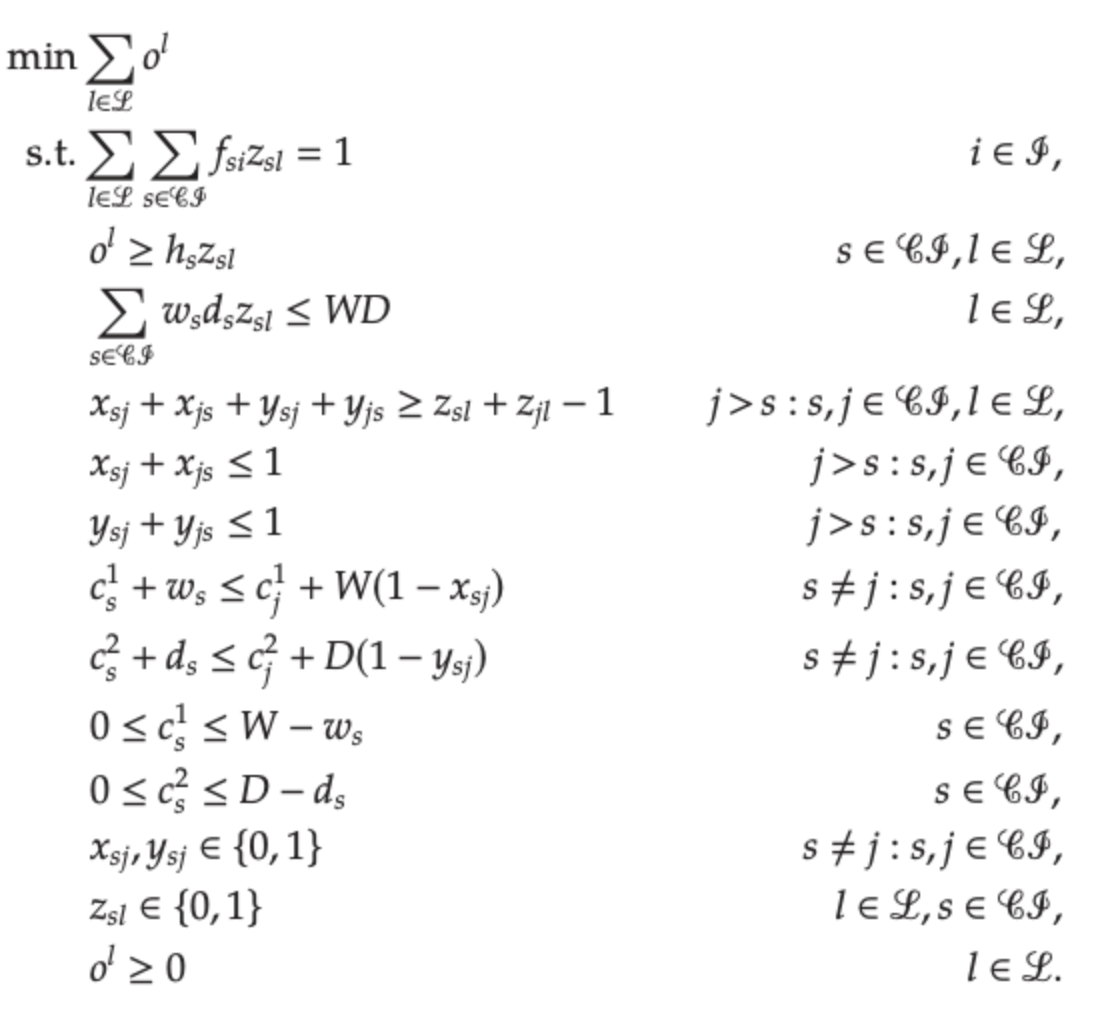

In [67]:
Image(filename='/Users/b0r07h4/Desktop/Work/BITS WORK SHOP/3d-bpp-main/assets/eqns.png',width=400)

In [26]:
superitems_horizontal=True
superitems_horizontal_type="two-width"
superitems_max_vstacked=4
superitems_list, singles_removed = SuperitemPool.gen_superitems(
    order=order,
    pallet_dims=config.PALLET_DIMS,
    only_single=True,
    max_vstacked=superitems_max_vstacked,
    horizontal=superitems_horizontal,
    horizontal_type=superitems_horizontal_type
)

2024-04-01 22:13:33.612 | DEBUG    | __main__:_gen_single_items_superitems:636 - Generated 2 superitems with a single item
2024-04-01 22:13:33.614 | INFO     | __main__:gen_superitems:617 - Generating superitems with only single items


In [27]:
superitems_list

[Superitem(ids=[0], width=433, depth=332, height=188, weight=2, volume=27026128, coords={0: Coordinate(x=0, y=0, z=0)}),
 Superitem(ids=[1], width=386, depth=270, height=386, weight=2, volume=40228920, coords={1: Coordinate(x=0, y=0, z=0)})]

In [28]:
superitems_pool = SuperitemPool(superitems=superitems_list)
superitems_pool

SuperitemPool(superitems=[Superitem(ids=[0], width=433, depth=332, height=188, weight=2, volume=27026128, coords={0: Coordinate(x=0, y=0, z=0)}), Superitem(ids=[1], width=386, depth=270, height=386, weight=2, volume=40228920, coords={1: Coordinate(x=0, y=0, z=0)})])

In [23]:
#initialization
model = cp_model.CpModel()
solver = cp_model.CpSolver()

In [31]:
fsi, _, _ = superitems_pool.get_fsi()
ws, ds, hs = superitems_pool.get_superitems_dims()
n_superitems, n_items = fsi.shape
max_layers = n_items
pallet_dims = config.PALLET_DIMS

### variables

In [32]:
# Layer heights variables
ol = {l: model.NewIntVar(0, max(hs), f"o_{l}") for l in range(max_layers)}
zsl, cix, ciy, xsj, ysj = dict(), dict(), dict(), dict(), dict()
for s in range(n_superitems):
    # Coordinate variables
    cix[s] = model.NewIntVar(0, int(pallet_dims.width - ws[s]), f"c_{s}_x")
    ciy[s] = model.NewIntVar(0, int(pallet_dims.depth - ds[s]), f"c_{s}_y")

    # Precedence variables
    for j in range(n_superitems):
        if j != s:
            xsj[s, j] = model.NewBoolVar(f"x_{s}_{j}")
            ysj[s, j] = model.NewBoolVar(f"y_{s}_{j}")

    # Superitems to layer assignment variables
    for l in range(max_layers):
        zsl[s, l] = model.NewBoolVar(f"z_{s}_{l}")

### Channeling variables

In [33]:
# same[s, j, l] = 1 iff superitems s and j are both in layer l
same = dict()
for l in range(max_layers):
    for s in range(n_superitems):
        for j in range(n_superitems):
            if j != s:
                same[s, j, l] = model.NewBoolVar(f"s_{s}_{j}_{l}")
                model.Add(same[s, j, l] == 1).OnlyEnforceIf([zsl[s, l], zsl[j, l]])
                model.Add(same[s, j, l] == 0).OnlyEnforceIf([zsl[s, l].Not(), zsl[j, l]])
                model.Add(same[s, j, l] == 0).OnlyEnforceIf([zsl[s, l], zsl[j, l].Not()])
                model.Add(same[s, j, l] == 0).OnlyEnforceIf([zsl[s, l].Not(), zsl[j, l].Not()])

### Constraints

### Ensure that every item is included in exactly one layer

In [34]:
for i in range(n_items):
    model.Add(
        cp_model.LinearExpr.Sum(
            [fsi[s, i] * zsl[s, l] for s in range(n_superitems) for l in range(max_layers)]
        )
        == 1
    )

### Define the height of layer l

In [35]:
for l in range(max_layers):
    for s in range(n_superitems):
        model.Add(ol[l] >= hs[s] * zsl[s, l])

### Redundant valid cuts that force the area of
### a layer to fit within the area of a bin

In [36]:

model.Add(
    cp_model.LinearExpr.Sum(
        [ws[s] * ds[s] * zsl[s, l] for l in range(max_layers) for s in range(n_superitems)]
    )
    <= pallet_dims.area
)

### Enforce at least one relative positioning relationship
### between each pair of items in a layer

In [37]:

for l in range(max_layers):
    for s in range(n_superitems):
        for j in range(n_superitems):
            if j > s:
                model.Add(xsj[s, j] + xsj[j, s] + ysj[s, j] + ysj[j, s] >= 1).OnlyEnforceIf(
                    [same[s, j, l]]
                )

### Ensure that there is at most one spatial relationship
### between items i and j along the width and depth dimensions

In [38]:

for l in range(max_layers):
    for s in range(n_superitems):
        for j in range(n_superitems):
            if j > s:
                model.Add(xsj[s, j] + xsj[j, s] <= 1).OnlyEnforceIf([same[s, j, l]])
                model.Add(ysj[s, j] + ysj[j, s] <= 1).OnlyEnforceIf([same[s, j, l]])

### Non-overlapping constraints

In [39]:
for l in range(max_layers):
    for s in range(n_superitems):
        for j in range(n_superitems):
            if j != s:
                model.Add(
                    cix[s] + ws[s] <= cix[j] + pallet_dims.width * (1 - xsj[s, j])
                ).OnlyEnforceIf([same[s, j, l]])
                model.Add(
                    ciy[s] + ds[s] <= ciy[j] + pallet_dims.depth * (1 - ysj[s, j])
                ).OnlyEnforceIf([same[s, j, l]])

### Minimize the sum of layer heights

In [40]:
obj = cp_model.LinearExpr.Sum([ol[l] for l in range(max_layers)])
model.Minimize(obj)

### Search by biggest area first

In [42]:
indices_by_area = argsort([ws[s] * ds[s] for s in range(n_superitems)], reverse=True)
model.AddDecisionStrategy(
    [cix[s] for s in indices_by_area],
    cp_model.CHOOSE_LOWEST_MIN,
    cp_model.SELECT_MIN_VALUE,
)

### Set a time limit

In [43]:
solver.parameters.max_time_in_seconds = 10

### Set solver parameters

In [45]:
solver.parameters.num_search_workers = 4
solver.parameters.log_search_progress = True
solver.parameters.search_branching = cp_model.FIXED_SEARCH

### Solve

In [46]:
status = solver.Solve(model)


Starting CP-SAT solver v9.5.2237
Parameters: max_time_in_seconds: 10 log_search_progress: true search_branching: FIXED_SEARCH num_search_workers: 4

Initial optimization model '': (model_fingerprint: 0x17f955ab0e9f41c4)
Search strategy: on 2 variables, CHOOSE_LOWEST_MIN, SELECT_MIN_VALUE
#Variables: 18 (#ints:2 in objective)
  - 12 Booleans in [0,1]
  - 2 in [0,386]
  - 1 in [0,468]
  - 1 in [0,530]
  - 1 in [0,767]
  - 1 in [0,814]
#kLinear1: 16 (#enforced: 16 #multi: 16)
#kLinear2: 10 (#enforced: 4)
#kLinear3: 8 (#enforced: 8)
#kLinearN: 3 (#enforced: 2) (#terms: 12)

Starting presolve at 0.00s
[ExtractEncodingFromLinear] #potential_supersets=0 #potential_subsets=0 #at_most_one_encodings=0 #exactly_one_encodings=0 #unique_terms=0 #multiple_terms=0 #literals=0 time=5e-06s
[Probing] deterministic_time: 1.334e-05 (limit: 1) wall_time: 8e-05 (16/16)
[Probing]  - new binary clause: 8
[Probing] implications and bool_or (work_done=320).
[SAT presolve] num removable Booleans: 2 / 18
[SAT pr

### Extract results

In [48]:
sol = dict()
if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    for l in range(max_layers):
        sol[f"o_{l}"] = solver.Value(ol[l])
        for s in range(n_superitems):
            sol[f"z_{s}_{l}"] = solver.Value(zsl[s, l])
    for s in range(n_superitems):
        sol[f"c_{s}_x"] = solver.Value(cix[s])
        sol[f"c_{s}_y"] = solver.Value(ciy[s])
    sol["objective"] = solver.ObjectiveValue()

In [74]:
!pwd


/Users/b0r07h4/Desktop/Work/BITS WORK SHOP/3d-bpp-main
